# Analysis of cell count per organoid
*Author: Felix Romer*<br/>
*Data: 27/02/2024*<br/>
<br/>
The underlying data is spinning disc microscopy data of organoids, stained with DAPI. Because of technical problems (strong bleaching for nuclei in lower half of organoids) only the top half of the organoids were counted. The radius in z as well as the diameter in x and y direction where measured. With that the surface of the ellipsoid describing the organoid will be calculated.<br/>
For some organoid the attempt was made to calculate all cells. This was often not too successful.

## 1. Set up
Imports, data loading, global variables  

In [7]:
# Import needed packages
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.special import ellipkinc, ellipeinc
from functions import ellipsoid_surface_area, extract_and_calculate
from matplotlib.legend_handler import HandlerTuple

#statistic
from statannot import add_stat_annotation
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load data
file_loc = 'Confocal image metrics data.xlsx'
RawData = pd.read_excel(file_loc)

# global variables
CF_xy = 1       # is already in µm
CF_z  = 2.25

## 2. Process data
* extract experiment conditions
* calculate ellipsoid surface area
* calculate other features of interest

In [12]:
# Peak into raw data
RawData.head(5)

,Name,number slices top half,small diameter µm,biggest diameter µm,number cells top half,note for top half,Data trustable,number cells,Note
0,Early life 1Control1 Ctrl 1,58,396.0,408.0,756.0,good signal,Yes,1254,"Total organoid nearls compleaty segmented, but..."
1,Early life 1Control1 Ctrl 2,73,450.0,505.0,1212.0,good signal,Yes,1317,nuclei signal very bad. Don’t knnow if we can ...
2,Early life 1Control1 Ctrl 3,38,249.0,264.0,193.0,good signal,Yes,254,good signal
3,Early life 1Control1 Ctrl 4,46,260.0,308.0,235.0,"top folded, but looks good",Yes,328,NaN
4,Early life 1Control1 Ctrl 5,77,442.0,518.0,970.0,signal get a little bad at bottom but looks good,Yes,979,NaN


In [3]:
# remove unneded columns
Data = RawData

# Define a regular expression to extract one and two-digit numbers within text
pattern = r'(?<!\d)(\d{1,2})(?!\d)'

# Extract meta data from Name column
Data['Replication']             = Data['Name'].str.findall(pattern).str[0].astype(int)
Data['Slide_number']            = Data['Name'].str.findall(pattern).str[1].astype(int)
Data['Organoid_number']         = Data['Name'].str.findall(pattern).str[2].astype(int)
Data['Category']                = Data['Name'].apply(lambda x: 'Control' if 'Control' in x else 'HP')
Data['Infection_time']          = Data['Name'].apply(lambda x: 'Early life' if 'Early life' in x else 'Late life')

# Scale data
Data['number slices top half']  = Data['number slices top half'].apply(extract_and_calculate)
Data['dz']                      = Data['number slices top half'] * CF_z


In [5]:
# Calculate surface of ellipsoid
Data['Ellipsoid_surface_area']  = Data.apply(lambda row: ellipsoid_surface_area(row['dz'], row['small diameter µm'], row['biggest diameter µm']), axis=1)
Data['cells_per_area']          = Data['number cells top half'] / Data['Ellipsoid_surface_area'] * 2
Data['cells_per_area_log']      = np.log(Data['cells_per_area'])

Data.head(5)

,Name,Experiment,Group,number slices top half,small diameter µm,biggest diameter µm,number cells top half,note for top half,Data trustable,number cells,Note,Replication,Slide_number,Organoid_number,Category,Infection_time,dz,Ellipsoid_surface_area,cells_per_area,cells_per_area_log
0,Early life 1Control1 Ctrl 1,EL1,Control,58.0,396.0,408.0,756.0,good signal,Yes,1254,"Total organoid nearls compleaty segmented, but...",1,1,1,Control,Early life,130.50,1.217802e+06,0.001242,-6.691370
1,Early life 1Control1 Ctrl 2,EL1,Control,73.0,450.0,505.0,1212.0,good signal,Yes,1317,nuclei signal very bad. Don’t knnow if we can ...,1,1,2,Control,Early life,164.25,1.741135e+06,0.001392,-6.576874
2,Early life 1Control1 Ctrl 3,EL1,Control,38.0,249.0,264.0,193.0,good signal,Yes,254,good signal,1,1,3,Control,Early life,85.50,4.989870e+05,0.000774,-7.164498
3,Early life 1Control1 Ctrl 4,EL1,Control,46.0,260.0,308.0,235.0,"top folded, but looks good",Yes,328,NaN,1,1,4,Control,Early life,103.50,6.245816e+05,0.000753,-7.192105
4,Early life 1Control1 Ctrl 5,EL1,Control,77.0,442.0,518.0,970.0,signal get a little bad at bottom but looks good,Yes,979,NaN,1,1,5,Control,Early life,173.25,1.780110e+06,0.001090,-6.821742


## 3. Statistical analysis

c:\Users\felix_9ny56v1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:292: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sub_data.loc[:, self.cat_axis] = adjusted_data


$\log\left(\frac{cells}{\mu\mathrm{m}^3}\right)$


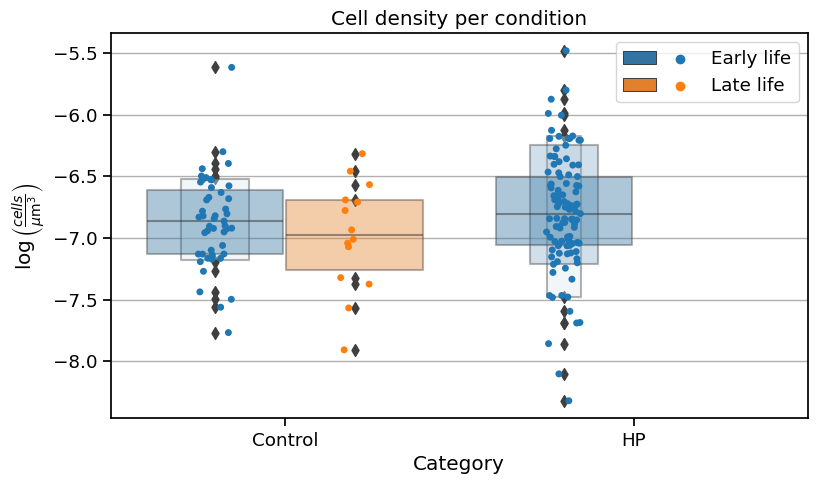

In [11]:
# Palette for violinplot and swarmplot

# Create figure and seaborn context
sns.set_context('notebook', font_scale=1.2)
fig, ax1 = plt.subplots(figsize=(9,5))

# Create the plot
sns.boxenplot(y="cells_per_area_log",
x="Category",
data=Data,
hue = 'Infection_time',
box_kws={'alpha': 0.4},
ax=ax1
)

sns.stripplot(data=Data,
y="cells_per_area_log",
x="Category", 
hue="Infection_time", 
dodge=True,
ax=ax1)


handles, labels = ax1.get_legend_handles_labels()

ax1.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=['Early life', 'Late life'],
          loc='best', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})



# Add grid
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_title('Cell density per condition')
print(r'$\log\left(\frac{cells}{\mu\mathrm{m}^3}\right)$')
ax1.set_ylabel(r'$\log\left(\frac{cells}{\mu\mathrm{m}^3}\right)$')

# Show the plot
plt.show()

## 4. Visualize Data